In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import pandas
import cv2
import matplotlib.pyplot as plt
import csv
import random
from skimage.transform import rotate
import joblib
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

#### Class names

In [3]:
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 metric tons"
}

#### Load Data

In [4]:
augmented_I_RGB = np.load('augmented_I_RGB.npy')      # Shape: (N, 32, 32, 3)
augmented_I_Gray = np.load('augmented_I_Gray.npy')    # Shape: (N, 32, 32)
augmented_L = np.load('augmented_L.npy')              # Shape: (N,)

#Verify shapes
print(f"RGB images: {augmented_I_RGB.shape}")
print(f"Grayscale images: {augmented_I_Gray.shape}")
print(f"Labels: {augmented_L.shape}")

RGB images: (78418, 32, 32, 3)
Grayscale images: (78418, 32, 32)
Labels: (78418,)


#### Simple CNN

In [5]:
model = models.Sequential()
#in
model.add(layers.InputLayer(input_shape=(32, 32,1)))
#Convolutional Block 1
model.add(layers.Conv2D(64, (5, 5), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())

# Conv Block 2
model.add(layers.Conv2D(128, (5, 5), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())
    
# Conv block 3
model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())

# Output block
model.add(layers.Flatten())
model.add(layers.Dense(43, activation='softmax'))

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
X = augmented_I_Gray
y = augmented_L  
print(len(X),len(y))

78418 78418


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
y_train_int = np.array(y_train).astype(int)
y_train_onehot = to_categorical(y_train_int, num_classes=43)

In [9]:
early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
)

In [10]:
history = model.fit(
    X_train, y_train_onehot,
    epochs=50,  # Set high since we're using early stopping
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
1569/1569 [==============================] - 14s 6ms/step - loss: 0.7723 - accuracy: 0.7954 - val_loss: 0.0557 - val_accuracy: 0.9845
Epoch 2/50
1569/1569 [==============================] - 9s 6ms/step - loss: 0.0366 - accuracy: 0.9899 - val_loss: 0.1053 - val_accuracy: 0.9672
Epoch 3/50
1569/1569 [==============================] - 9s 6ms/step - loss: 0.0249 - accuracy: 0.9924 - val_loss: 0.0182 - val_accuracy: 0.9944
Epoch 4/50
1569/1569 [==============================] - 9s 6ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0341 - val_accuracy: 0.9888
Epoch 5/50
1569/1569 [==============================] - 9s 6ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0143 - val_accuracy: 0.9952
Epoch 6/50
1569/1569 [==============================] - 9s 6ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.0167 - val_accuracy: 0.9947
Epoch 7/50
1569/1569 [==============================] - 9s 6ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0274 - val_accuracy

#### Evaluation


                 TRAINING METRICS                 
Training Accuracy:       0.9997
Training Loss:           0.0013

                   TEST METRICS                   
Test Accuracy:           0.9994
Test Loss:               0.0022
Precision:               0.9994
Recall:                  0.9994
F1-Score:                0.9994


          DETAILED CLASSIFICATION REPORT          
              precision    recall  f1-score   support

           0     0.9882    1.0000    0.9941        84
           1     1.0000    1.0000    1.0000       888
           2     0.9989    1.0000    0.9994       900
           3     1.0000    0.9965    0.9982       564
           4     1.0000    1.0000    1.0000       792
           5     0.9973    1.0000    0.9987       744
           6     1.0000    1.0000    1.0000       168
           7     1.0000    0.9965    0.9983       576
           8     1.0000    1.0000    1.0000       564
           9     1.0000    1.0000    1.0000       588
          10     1.0000 

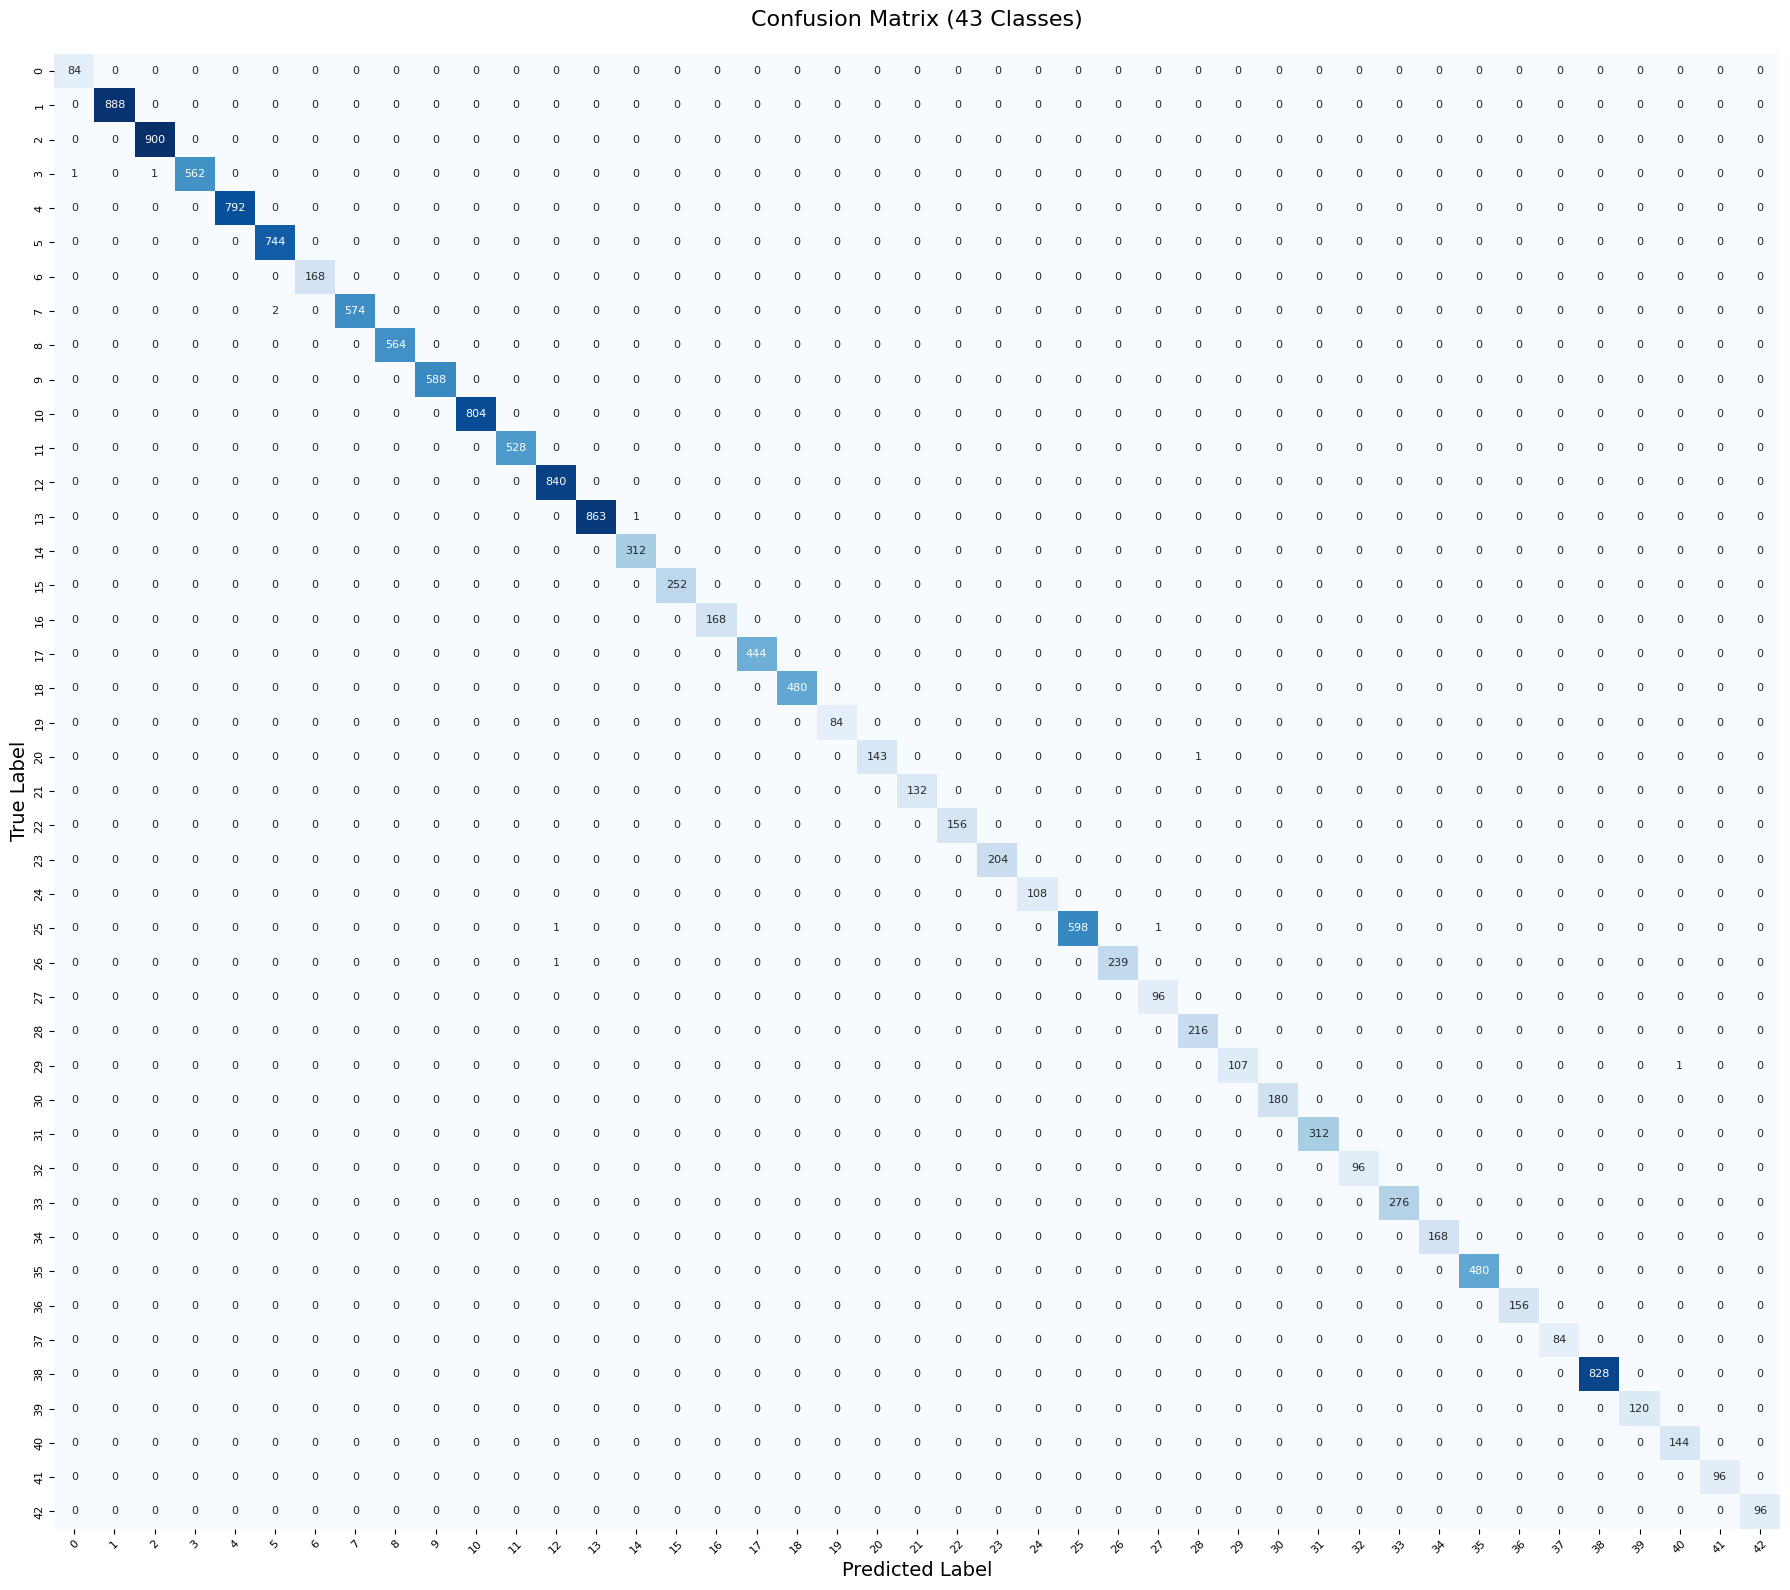

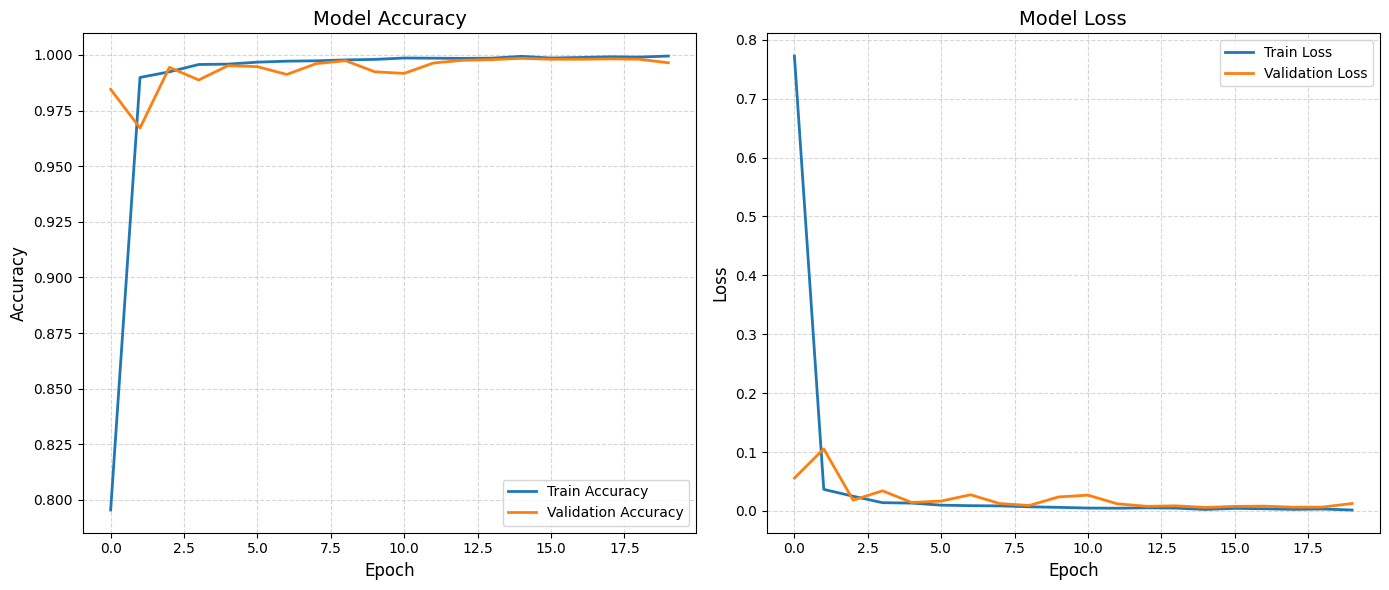

In [11]:
y_test_int = np.array(y_test).astype(int)
y_test_onehot = to_categorical(y_test_int, num_classes=43)
y_train_int = np.array(y_train).astype(int)

#training metrics
train_loss, train_acc = model.evaluate(X_train, to_categorical(y_train_int, num_classes=43), verbose=0)
y_train_pred = model.predict(X_train, verbose=0)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

#Test evaluation
test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

#Calculate metrics
precision = precision_score(y_test_int, y_pred_classes, average='weighted')
recall = recall_score(y_test_int, y_pred_classes, average='weighted')
f1 = f1_score(y_test_int, y_pred_classes, average='weighted')

#Print metrics
print("\n" + "="*50)
print(f"{'TRAINING METRICS':^50}")
print("="*50)
print(f"{'Training Accuracy:':<25}{train_acc:.4f}")
print(f"{'Training Loss:':<25}{train_loss:.4f}\n")

print("="*50)
print(f"{'TEST METRICS':^50}")
print("="*50)
print(f"{'Test Accuracy:':<25}{test_acc:.4f}")
print(f"{'Test Loss:':<25}{test_loss:.4f}")
print(f"{'Precision:':<25}{precision:.4f}")
print(f"{'Recall:':<25}{recall:.4f}")
print(f"{'F1-Score:':<25}{f1:.4f}")
print("="*50 + "\n")

#Classification Report
print("\n" + "="*50)
print(f"{'DETAILED CLASSIFICATION REPORT':^50}")
print("="*50)
print(classification_report(y_test_int, y_pred_classes, digits=4))
print("="*50 + "\n")

#Confusion Matrix
plt.figure(figsize=(18, 16))
cm = confusion_matrix(y_test_int, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(43), yticklabels=range(43),
            annot_kws={"size": 8}, cbar=False)
plt.title('Confusion Matrix (43 Classes)', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

#Enhanced Training History Visualization
plt.figure(figsize=(14, 6))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

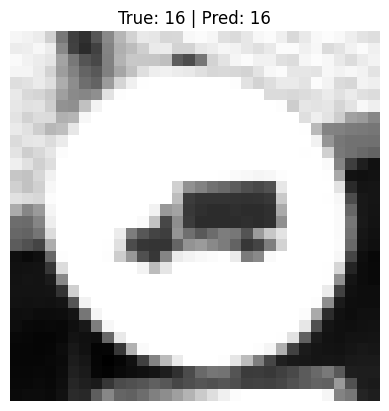

Inference time: 35.79ms
True label: 16 | Predicted: 16
Confidence: 100.00%


In [12]:
import time

def test_random_sample(model):
    idx = np.random.randint(len(augmented_I_Gray))   #Pick random index
    img, label = augmented_I_Gray[idx], augmented_L[idx]
    
    # Prepare image (add batch dim + normalize)
    x = np.expand_dims(img, axis=0)  # Shape: (1, 32, 32, 1)
    
    #Warm-up
    model.predict(x, verbose=0)
    
    #Time inference (average over 10 runs)
    times = []
    for _ in range(10):
        start = time.time()
        pred = model.predict(x, verbose=0)
        times.append(time.time() - start)
    
    avg_time = np.mean(times) * 1000  #Average all measured runs
    
    #Display
    plt.imshow(img,cmap="gray") 
    plt.title(f"True: {label} | Pred: {np.argmax(pred)}")
    plt.axis('off')
    plt.show()
    
    print(f"Inference time: {avg_time:.2f}ms")
    print(f"True label: {label} | Predicted: {np.argmax(pred)}")
    print(f"Confidence: {np.max(pred):.2%}")

test_random_sample(model)

In [13]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
tracker.start()
model.predict(X_test)
emissions_SCNNG = tracker.stop()
print(f"Emissions for Random Forest: {emissions_SCNNG} kg CO2")

[codecarbon WARNING @ 10:28:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:28:15] [setup] RAM Tracking...
[codecarbon INFO @ 10:28:15] [setup] CPU Tracking...
[codecarbon WARNING @ 10:28:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:28:16] CPU Model on constant consumption mode: AMD Ryzen 9 5900XT 16-Core Processor
[codecarbon WARNING @ 10:28:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:28:16] [setup] GPU Tracking...
[codecarbon INFO @ 10:28:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:28:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 10:28:16] >>> Tracker's metad

491/491 [==============================] - 1s 2ms/step


[codecarbon INFO @ 10:28:21] Energy consumed for RAM : 0.000007 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:28:21] Delta energy consumed for CPU with constant : 0.000577 kWh, power : 1680.0 W
[codecarbon INFO @ 10:28:21] Energy consumed for All CPU : 0.000577 kWh
[codecarbon INFO @ 10:28:21] Energy consumed for all GPUs : 0.000015 kWh. Total GPU Power : 44.947130911964656 W
[codecarbon INFO @ 10:28:21] 0.000600 kWh of electricity used since the beginning.


Emissions for Random Forest: 0.00017434596028612984 kg CO2
